Purpose: Pull out top predictors (genes) from random forest results.<br>
Author: Anna Pardo<br>
Date initiated: July 3, 2023

In [26]:
# load modules
import pandas as pd
import statistics
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# load data: feature importances
cfi = pd.read_csv("../../data/rf_outputs/ColdTest_Up_Feature_Importances_sorted.tsv",sep="\t",header="infer")
dfi = pd.read_csv("../../data/rf_outputs/DroughtTest_Up_Feature_Importances_sorted.tsv",sep="\t",header="infer")
ffi = pd.read_csv("../../data/rf_outputs/FloodingTest_Up_Feature_Importances_sorted.tsv",sep="\t",header="infer")
hfi = pd.read_csv("../../data/rf_outputs/HeatTest_Up_Feature_Importances_sorted.tsv",sep="\t",header="infer")
sfi = pd.read_csv("../../data/rf_outputs/SaltTest_Up_Feature_Importances_sorted.tsv",sep="\t",header="infer")

In [3]:
# load data: log fold change for stressed vs. control overall
lfc = pd.read_csv("../../data/log2FoldChange_allStress_meanTPM.tsv",sep="\t",header="infer")
lfc.head()

,GeneID,Control,Stressed,log2FoldChange,FoldChange
0,Zm00001eb000010,8.727933,9.924736,0.167393,1.123028
1,Zm00001eb000020,28.632358,21.016712,-0.428574,0.742996
2,Zm00001eb000050,0.268449,0.380455,0.122079,1.088302
3,Zm00001eb000060,14.146914,13.191133,-0.094034,0.936899
4,Zm00001eb000070,1.579068,2.501370,0.441070,1.357611


Overall strategy: iterate through different cutoff sizes (top 100 predictors, etc.) and test for enrichment in highly "DE" (high absolute value log fold change) genes

In [4]:
# To figure out the method, try with the top 50 genes for cold as the test data (cfi)
## pull out the top 50 genes given that the feature importance dataframes are sorted in descending order

top50 = cfi.head(n=50)

In [8]:
cfi.head()

,GeneID,Feature_Importance
0,Zm00001eb330160,0.002918
1,Zm00001eb419870,0.002859
2,Zm00001eb397600,0.002799
3,Zm00001eb388760,0.002546
4,Zm00001eb351790,0.002522


In [5]:
# calculate absolute value in the log fold change data
lfc["absLFC"] = abs(lfc["log2FoldChange"])
lfc.head()

,GeneID,Control,Stressed,log2FoldChange,FoldChange,absLFC
0,Zm00001eb000010,8.727933,9.924736,0.167393,1.123028,0.167393
1,Zm00001eb000020,28.632358,21.016712,-0.428574,0.742996,0.428574
2,Zm00001eb000050,0.268449,0.380455,0.122079,1.088302,0.122079
3,Zm00001eb000060,14.146914,13.191133,-0.094034,0.936899,0.094034
4,Zm00001eb000070,1.579068,2.501370,0.441070,1.357611,0.441070


In order to set up for Fisher's exact test, I need to decide what is the cutoff for a "high" log fold change.

In [6]:
# get summary statistics about absolute value of log fold change, overall
print("maximum absolute value log fold change: ",max(lfc["absLFC"]))
print("minimum absolute value log fold change: ",min(lfc["absLFC"]))
print("mean absolute value log fold change: ",sum(lfc["absLFC"])/len(lfc["absLFC"]))
print("median absolute value log fold change: ",statistics.median(lfc["absLFC"]))

maximum absolute value log fold change:  3.61572986597464
minimum absolute value log fold change:  0.0
mean absolute value log fold change:  0.19287408281692117
median absolute value log fold change:  0.12040564789173219


In [7]:
# get quartiles
lfc["absLFC"].quantile([0.99])

0.99    1.183755
Name: absLFC, dtype: float64

I will define "high log change" as the 99th percentile of absolute value log fold change or above (translates to a log fold change value of 1.183755). This constitutes 1% of genes, or about 390.

In [8]:
# set high log fold change cutoff value
hl = 1.183755

In [9]:
# set up a variable to indicate whether LFC is high or low
lfchl = []
for i in list(lfc["absLFC"]):
    if i >= hl:
        lfchl.append("High")
    else:
        lfchl.append("Low")
lfc["LFC_High_Low"] = lfchl
lfc.head()

,GeneID,Control,Stressed,log2FoldChange,FoldChange,absLFC,LFC_High_Low
0,Zm00001eb000010,8.727933,9.924736,0.167393,1.123028,0.167393,Low
1,Zm00001eb000020,28.632358,21.016712,-0.428574,0.742996,0.428574,Low
2,Zm00001eb000050,0.268449,0.380455,0.122079,1.088302,0.122079,Low
3,Zm00001eb000060,14.146914,13.191133,-0.094034,0.936899,0.094034,Low
4,Zm00001eb000070,1.579068,2.501370,0.441070,1.357611,0.441070,Low


In [10]:
# merge lfc with feature importance data
cfi_lfc = cfi.merge(lfc[["GeneID","absLFC","LFC_High_Low"]])
cfi_lfc.head()

,GeneID,Feature_Importance,absLFC,LFC_High_Low
0,Zm00001eb330160,0.002918,1.370069,High
1,Zm00001eb419870,0.002859,2.371348,High
2,Zm00001eb397600,0.002799,2.433645,High
3,Zm00001eb388760,0.002546,0.668850,Low
4,Zm00001eb351790,0.002522,3.076620,High


In [11]:
# set up a variable saying whether each gene is in the top set or not
topset = []
for i in cfi_lfc["GeneID"]:
    if i in list(top50["GeneID"]):
        topset.append("Top")
    else:
        topset.append("Bottom")
cfi_lfc["TopBottom"] = topset
cfi_lfc.head()

,GeneID,Feature_Importance,absLFC,LFC_High_Low,TopBottom
0,Zm00001eb330160,0.002918,1.370069,High,Top
1,Zm00001eb419870,0.002859,2.371348,High,Top
2,Zm00001eb397600,0.002799,2.433645,High,Top
3,Zm00001eb388760,0.002546,0.668850,Low,Top
4,Zm00001eb351790,0.002522,3.076620,High,Top


In [12]:
# set up the table for Fisher's exact test
data = pd.crosstab(index=cfi_lfc["LFC_High_Low"],columns=cfi_lfc["TopBottom"])
data

TopBottom,Bottom,Top
LFC_High_Low,,
High,356,35
Low,38589,15


In [13]:
# run Fisher's exact test
odd_ratio, p_value = stats.fisher_exact(data)

In [14]:
print('odd ratio is : ' + str(odd_ratio))
print('p_value is : ' + str(p_value))

odd ratio is : 0.003953754400772981
p_value is : 4.575943459720068e-59


In the above example, the p-value is less than 0.05, indicating that the top 50 genes are significantly enriched in high log fold change under all stressors.<br><br>
While this is a good example to show how the code will work, the question remains: what log fold change data should be used? Should it be for all stressors combined, or for each individual stressor? And should we use fold change or log fold change?<br><br>
If we use fold change (TN-ratio), it will be consistent with the set operations methods used elsewhere in this project. Is that a good thing, or will it confound methods that are supposed to be independent and redundant?

In [6]:
# stepwise by 50 in terms of set size, plot percent overlap among stressors vs. number of overlapping genes
## fold change cutoff: less than 0.5 or greater than 2
## use fold change for individual stressors

# load fold change dataframes for individual stressors
cfc = pd.read_csv("../../data/log2FoldChange_Cold_meanTPM.tsv",sep="\t",header="infer")
dfc = pd.read_csv("../../data/log2FoldChange_Drought_meanTPM.tsv",sep="\t",header="infer")
ffc = pd.read_csv("../../data/log2FoldChange_Flooding_meanTPM.tsv",sep="\t",header="infer")
hfc = pd.read_csv("../../data/log2FoldChange_Heat_meanTPM.tsv",sep="\t",header="infer")
sfc = pd.read_csv("../../data/log2FoldChange_Salt_meanTPM.tsv",sep="\t",header="infer")

In [7]:
cfc.head()

,GeneID,Cold,Control,log2FoldChange,FoldChange
0,Zm00001eb000010,7.903734,10.680200,-0.391583,0.762293
1,Zm00001eb000020,70.170136,65.105633,0.106499,1.076612
2,Zm00001eb000050,0.268680,0.305239,-0.040985,0.971991
3,Zm00001eb000060,18.077522,22.476354,-0.299335,0.812627
4,Zm00001eb000070,0.293699,0.373775,-0.086644,0.941711


In [31]:
10-2**3

2

In [52]:
# make function for calculating number of overlaps expected by random chance
def random_chance_overlaps(n,g,x):
    """
    Args:
        n = number of top features selected (i.e. 50, 100, ...)
        g = number of genes (union of all selected sets)
        x = number of sets (e.g. number of stressors)
    """
    a = 1/g
    c = a**x
    d = 1-c
    rco = n*d
    return rco

In [44]:
# actually don't need to use the fold change right now
# write a function to pull out the overlap and percent overlap for the top X genes
def get_overlap(n,dfdict):
    # make a list of sets of the top n predictors
    topn = []
    for k in dfdict:
        df = dfdict[k].head(n=n)
        topn.append(set(list(df["GeneID"])))
    # find how many top predictor genes overlap among all stressors
    n_overlap = len(set.intersection(*topn))
    # find percent overlap
    p_overlap = (n_overlap/len(set.union(*topn)))*100
    # return the variables
    return n_overlap, p_overlap, len(set.union(*topn))

In [22]:
# make dictionary of feature importance dataframes
allfi = {"Cold":cfi,"Drought":dfi,"Flooding":ffi,"Heat":hfi,"Salt":sfi}

In [53]:
# iterate through set sizes from 50-1000 with a step size of 50
## save the number and percent of overlaps and the set size in a dataframe
n_overlap_list = []
p_overlap_list = []
rc_noverlap_list = []
rc_poverlap_list = []
setsize_list = []
for i in range(50,1050,50):
    setsize_list.append(i)
    no, po, usize = get_overlap(i,allfi)
    n_overlap_list.append(no)
    p_overlap_list.append(po)
    n_rco = random_chance_overlaps(n=i,g=len(allfi["Cold"].index),x=len(allfi.keys()))
    rc_noverlap_list.append(n_rco)
    rc_poverlap_list.append((n_rco/usize)*100)
iterdf = pd.DataFrame(list(zip(setsize_list,n_overlap_list,p_overlap_list,rc_noverlap_list,rc_poverlap_list)),
                      columns=["Set Size","N_Overlap","Percent_Overlap","N_RC_Overlap","Percent_RC_Overlap"])
iterdf.head()

,Set Size,N_Overlap,Percent_Overlap,N_RC_Overlap,Percent_RC_Overlap
0,50,1,0.662252,50.0,33.112583
1,100,1,0.363636,100.0,36.363636
2,150,4,1.025641,150.0,38.461538
3,200,7,1.343570,200.0,38.387716
4,250,11,1.726845,250.0,39.246468


In [54]:
iterdf.tail()

,Set Size,N_Overlap,Percent_Overlap,N_RC_Overlap,Percent_RC_Overlap
15,800,54,2.706767,800.0,40.100251
16,850,62,2.905342,850.0,39.831303
17,900,65,2.860915,900.0,39.612676
18,950,66,2.727273,950.0,39.256198
19,1000,68,2.659366,1000.0,39.108330


In [49]:
g = len(allfi["Cold"].index)
g

38995

In [57]:
(1/g)**5

1.1090608543536326e-23

In [58]:
(50*(1/38995))*5

0.006411078343377357

In [60]:
((1/38995)**50)*(50*5)

7.038721385343672e-228

Text(0.5, 1.0, 'Set sizes 50-1000, step size 50')

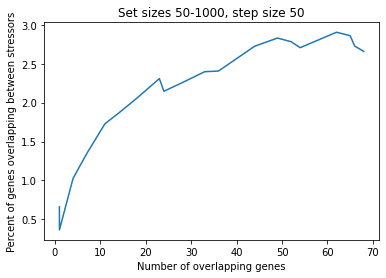

In [36]:
# plot number of overlapping genes vs. percent of genes that overlapped
plt.plot(iterdf["N_Overlap"],iterdf["Percent_Overlap"])
plt.xlabel("Number of overlapping genes")
plt.ylabel("Percent of genes overlapping between stressors")
plt.title("Set sizes 50-1000, step size 50")